In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
import shutil
import sys
import warnings
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
from pathlib import Path
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
)
from albumentations import (
    Compose, 
    ShiftScaleRotate,
)
from wandb.keras import WandbCallback

sys.path.append("..")
from utils.common import get_elapsed_time
from utils.data_utils import (
    identity_function,
    load_tfrecord_dataset,
    mixup_dataset,
)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore")
np.random.seed(42)

In [3]:
def view_img(dataset, n_samples, label_names=None):
    img_arrs, labels = next(iter(dataset))
    img_arrs = img_arrs.numpy()
    labels = np.argmax(labels.numpy(), axis=1)

    n_cols = 5
    n_rows = n_samples // n_cols if n_samples % n_cols == 0 else n_samples // n_cols + 1
    fig = plt.figure(figsize=(n_cols * 4, n_rows * 3))
    for i in range(n_samples):
        ax = fig.add_subplot(n_rows, n_cols, i + 1, xticks=[], yticks=[])
        ax.imshow(img_arrs[i])
        label = (
            labels[i].decode("utf-8")
            if label_names is None
            else label_names[f"c{str(labels[i])}"]
        )
        ax.set_title(f"Label: {label}")
        ax.axis("off")

In [4]:
config = configparser.ConfigParser()
_ = config.read(os.path.join("..", "conf", "config.ini"))

use_pseudo_label = False

project_name = config["project"]["project_name"]
run_name = config["project"]["run_name"]
raw_data_path = config["project"]["raw_data_path"]
raw_data_path = (
    os.path.join(raw_data_path, "pseudo_label") if use_pseudo_label else raw_data_path
)

model_url = config["model"]["model_url"]
fc_size = eval(config["model"]["fc_size"])
img_size = eval(config["model"]["img_size"])
n_epochs = eval(config["model"]["n_epochs"])
batch_size = eval(config["model"]["batch_size"])
initial_learning_rate = eval(config["model"]["initial_learning_rate"])
first_decay_steps = eval(config["model"]["first_decay_steps"])
use_adamw = eval(config["model"]["use_adamw"])
use_swa = eval(config["model"]["use_swa"])
use_mixup = eval(config["model"]["use_mixup"])
label_smoothing = eval(config["model"]["label_smoothing"])
pseudo_label_thr = eval(config["model"]["pseudo_label_thr"])
n_train_splits = eval(config["model"]["n_train_splits"])
n_test_splits = eval(config["model"]["n_test_splits"])

label_names = {
    "c0": "safe driving",
    "c1": "texting - right",
    "c2": "talking on the phone - right",
    "c3": "texting - left",
    "c4": "talking on the phone - left",
    "c5": "operating the radio",
    "c6": "drinking",
    "c7": "reaching behind",
    "c8": "hair and makeup",
    "c9": "talking to passenger",
}

labels = list(label_names.keys())
num_classes = len(label_names)

In [5]:
run = wandb.init(project=project_name, reinit=False)

if len(run_name) > 0:
    wandb.run.name = run_name
    wandb.run.save()

wandb.config.update(
    {
        "model_url": model_url,
        "fc_size": fc_size,
        "img_size": img_size,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "initial_learning_rate": initial_learning_rate,
        "first_decay_steps": first_decay_steps,
        "use_adamw": use_adamw,
        "use_swa": use_swa,
        "use_mixup": use_mixup,
        "label_smoothing": label_smoothing,
        "use_pseudo_label": use_pseudo_label,
        "pseudo_label_thr": pseudo_label_thr,
        "n_train_splits": n_train_splits,
        "n_test_splits": n_test_splits,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ... (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## An Input Data Pipeline Configuration with *Dataset* API

In [6]:
train_raw_data_path = os.path.join(raw_data_path, "imgs", "train")
test_raw_data_path = os.path.join(raw_data_path, "imgs", "test")

n_train_examples = len(
    tf.io.gfile.glob(os.path.join(train_raw_data_path, "*", "*.jpg"))
)
test_ids = [
    os.path.basename(img_path)
    for img_path in np.sort(tf.io.gfile.glob(os.path.join(test_raw_data_path, "*.jpg")))
]
n_test_examples = len(test_ids)

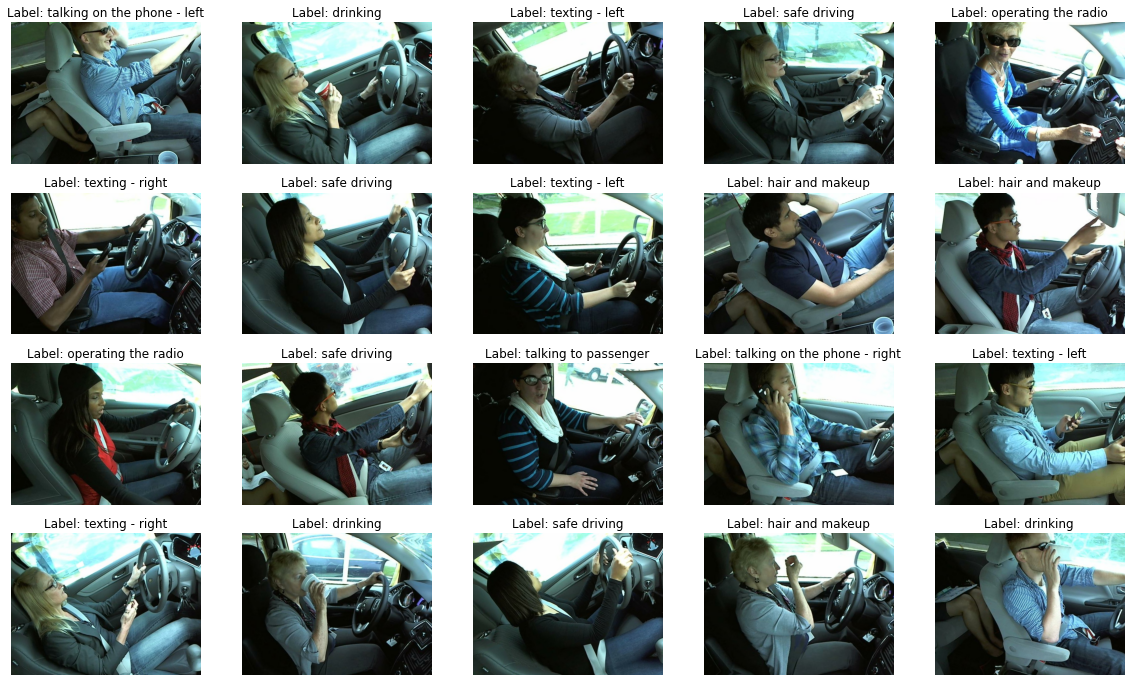

In [7]:
train_tfrec_paths = tf.io.gfile.glob(
    os.path.join(raw_data_path, "tfrec", "train", "*.tfrec")
)
test_tfrec_paths = np.sort(
    tf.io.gfile.glob(os.path.join(raw_data_path, "tfrec", "test", "*.tfrec"))
).tolist()

train_transforms = Compose(
    [
        ShiftScaleRotate(
            rotate_limit=(-20, 20),
            scale_limit=(0.0, 0.2),
            shift_limit_x=(-0.0625, 0.0625),
            shift_limit_y=(-0.046875, 0.046875),
            p=1.0,
        ),
    ]
)
valid_transforms = train_transforms

if n_test_splits > 1:
    test_transforms = train_transforms
else:
    test_transforms = identity_function

n_samples = 20
sampled_dataset = load_tfrecord_dataset(
    [train_tfrec_paths[0]],
    (480, 640),
    train_transforms,
    n_samples,
    num_classes=num_classes,
)

view_img(sampled_dataset, n_samples, label_names)

## Building and Compiling a Model

In [8]:
def get_model(
    model_url,
    img_size,
    fc_size,
    num_classes,
    initial_learning_rate,
    first_decay_steps,
    use_adamw,
    use_swa,
    label_smoothing,
    verbose=False,
):
    model = tf.keras.Sequential(
        [
            hub.KerasLayer(
                model_url, trainable=False, input_shape=(img_size, img_size, 3)
            ),
            tf.keras.layers.Dense(fc_size, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(fc_size, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )
    if verbose:
        print(model.summary())

    # For tensorflow 2.5 or later, use tf.keras.optimizers.schedules.CosineDecayRestarts.
    lr_decayed_fn = tf.keras.experimental.CosineDecayRestarts(
        initial_learning_rate, first_decay_steps
    )
    optimizer = (
        tfa.optimizers.AdamW(lr_decayed_fn)
        if use_adamw
        else tfa.optimizers.RectifiedAdam(lr_decayed_fn)
    )
    if use_swa:
        optimizer = tfa.optimizers.SWA(optimizer, start_averaging=0, average_period=10)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        metrics=["acc"],
    )

    return model

## Model Training and Prediction

In [9]:
test_size = 1 / n_train_splits if n_train_splits > 1 else 0.25
train_steps_per_epoch = round(n_train_examples * (1.0 - test_size) / batch_size)
valid_steps_per_epoch = round(n_train_examples * test_size / batch_size)

test_dataset = load_tfrecord_dataset(
    test_tfrec_paths,
    img_size,
    test_transforms,
    1,
    shuffle=False,
    num_classes=num_classes,
    is_prediction=True,
)

if n_train_splits > 1:
    kf = KFold(n_splits=n_train_splits, shuffle=True, random_state=42)
    split = kf.split(range(len(train_tfrec_paths)))
else:
    rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    split = rs.split(range(len(train_tfrec_paths)))

model_path = os.path.join("..", "models")
model_path = (
    os.path.join(model_path, "pseudo_label") if use_pseudo_label else model_path
)
prediction_path = os.path.join("..", "predictions")
prediction_path = (
    os.path.join(prediction_path, "pseudo_label")
    if use_pseudo_label
    else prediction_path
)

os.makedirs(model_path, exist_ok=True)
os.makedirs(prediction_path, exist_ok=True)

In [10]:
for i, (train_index, valid_index) in enumerate(split):
    with get_elapsed_time():
        one_train_dataset = load_tfrecord_dataset(
            np.array(train_tfrec_paths)[train_index],
            img_size,
            train_transforms,
            batch_size,
            num_classes=num_classes,
        )

        if use_mixup:
            oth_train_dataset = load_tfrecord_dataset(
                np.array(train_tfrec_paths)[train_index],
                img_size,
                train_transforms,
                batch_size,
                num_classes=num_classes,
            )
            zipped = tf.data.Dataset.zip((one_train_dataset, oth_train_dataset))
            train_dataset = zipped.map(
                lambda x, y: mixup_dataset(x, y, alpha=0.2),
                num_parallel_calls=tf.data.experimental.AUTOTUNE,
            )
        else:
            train_dataset = one_train_dataset

        valid_dataset = load_tfrecord_dataset(
            np.array(train_tfrec_paths)[valid_index],
            img_size,
            valid_transforms,
            batch_size,
            num_classes=num_classes,
        )

        if n_train_splits > 1:
            suffix = "_" + str(i).zfill(2)
            print(f"Model training started on the {i + 1} of {n_train_splits} CV sets.")
        else:
            suffix = ""

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10, restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                os.path.join(model_path, f"model{suffix}.h5"),
                monitor="val_loss",
            ),
            WandbCallback(),
        ]

        model = get_model(
            model_url,
            img_size,
            fc_size,
            num_classes,
            initial_learning_rate,
            first_decay_steps,
            use_adamw,
            use_swa,
            label_smoothing,
        )

        model.fit(
            train_dataset,
            epochs=n_epochs,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=valid_dataset,
            validation_steps=valid_steps_per_epoch,
            callbacks=callbacks,
        )

        for j in range(n_test_splits):
            if n_test_splits > 1:
                print(
                    f"Model prediction started with {j + 1} out of {n_test_splits} TTAs."
                )

            prediction = model.predict(
                test_dataset,
                steps=n_test_examples,
                use_multiprocessing=True,
            )

            if j == 0:
                predictions = prediction
            else:
                predictions += prediction

        predictions /= n_test_splits
        predictions = pd.DataFrame(predictions, columns=labels, index=test_ids)
        predictions.index.name = "img"
        predictions.to_csv(os.path.join(prediction_path, f"pred{suffix}.csv"))

        if i == 0:
            result = predictions
        else:
            result += predictions

result /= n_train_splits
if use_pseudo_label:
    plabeled = pd.read_csv(
        os.path.join(Path(prediction_path).parent, "submission.csv"), index_col=0
    )
    result = pd.concat([result, plabeled.loc[plabeled.index.difference(result.index)]])
    result.index.name = "img"

result.to_csv(os.path.join(prediction_path, "submission.csv"))

print("The model training and prediction tasks have been successfully completed.")

Epoch 1/500
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-03-16 15:40:15.113 tensorflow-2-6-gpu-p-ml-p3-2xlarge-0d90a33bec970cd9f3bcca70fc5a:20361 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-03-16 15:40:15.148 tensorflow-2-6-gpu-p-ml-p3-2xlarge-0d90a33bec970cd9f3bcca70fc5a:20361 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
526/526 [==============================] - 135s 226ms/step - loss: 1.0089 - acc: 0.6520 - val_loss: 0.3415 - val_acc: 0.8961
Epoch 2/500
526/526 [==============================] - 112s 214ms/step - loss: 0.3441 - acc: 0.8947 - val_loss: 0.5457 - val_acc: 0.7957
Epoch 3/500
526/526 [=========

In [11]:
lowest_conf_ids = result.max(axis=1).sort_values()[:n_samples].index.tolist()
lowest_conf_result = result.loc[lowest_conf_ids].values

columns = ["image_id", "image", "label", "proba"]
data = []
for each_id, label, proba in zip(
    lowest_conf_ids,
    lowest_conf_result.argmax(axis=1),
    lowest_conf_result.max(axis=1),
):
    data.append(
        [
            each_id,
            wandb.Image(os.path.join(test_raw_data_path, each_id)),
            label_names[f"c{str(label)}"],
            round(proba, 6),
        ]
    )

lowest_conf_img_table = wandb.Table(data=data, columns=columns)
wandb.log({"lowest_conf_img_table": lowest_conf_img_table})
run.finish()

acc,▁▆▅▆▇▇▆▆▇▇███▆▆▇▇▇▇▇████████▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▃▄▃▂▂▄▃▂▂▁▁▁▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▂▃▂▂▂▂▂▂▂
val_acc,▅▁▆▇▇▆▆▇▇████▅▇▇▇▇██████████▇▇▇▇█████
val_loss,▅█▄▂▂▄▄▃▂▂▁▁▁▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▃▂▂▂▂▂▁▁▁
acc,0.96097
best_epoch,26
best_val_loss,0.04006
epoch,36
loss,0.13431
val_acc,0.97982


## Data Preparation for Pseudo Labeling

In [12]:
if not use_pseudo_label:
    plabeled_data_path = os.path.join(raw_data_path, "pseudo_label")
    train_plabeled_data_path = os.path.join(plabeled_data_path, "imgs", "train")
    test_plabeled_data_path = os.path.join(plabeled_data_path, "imgs", "test")

    if os.path.exists(train_plabeled_data_path):
        shutil.rmtree(train_plabeled_data_path)

    if os.path.exists(test_plabeled_data_path):
        shutil.rmtree(test_plabeled_data_path)

    shutil.copytree(train_raw_data_path, train_plabeled_data_path)

    plabeled = result[result.max(axis=1) > pseudo_label_thr]

    for file_name, label in zip(plabeled.index, plabeled.values.argmax(axis=1)):
        shutil.copyfile(
            os.path.join(test_raw_data_path, file_name),
            os.path.join(train_plabeled_data_path, f"c{label}", file_name),
        )

    os.makedirs(test_plabeled_data_path, exist_ok=True)
    not_plabeled = result[~(result.max(axis=1) > pseudo_label_thr)]

    for file_name in not_plabeled.index:
        shutil.copyfile(
            os.path.join(test_raw_data_path, file_name),
            os.path.join(test_plabeled_data_path, file_name),
        )